In [ ]:
from google.colab import auth
from google.cloud import bigquery

# Authenticate to GCP
auth.authenticate_user()

# Construct a BigQuery client object.
client = bigquery.Client(project='testproject-1ec45')

# Define your query
# query = """
#     SELECT *
#     FROM `physionet-data.mimiciv_note.radiology`
#     LIMIT 100 # Consider adding a limit for testing or smaller datasets
# """
query = """
SELECT
  r.note_id,
  r.subject_id,
  r.hadm_id,
  r.note_type,
  r.note_seq,
  r.charttime,
  r.storetime,
  r.text,
  rd.field_name,
  rd.field_value,
  rd.field_ordinal
FROM `physionet-data.mimiciv_note.radiology` r
JOIN `physionet-data.mimiciv_note.radiology_detail` rd
ON r.note_id = rd.note_id
WHERE r.text IS NOT NULL
ORDER BY RAND()
LIMIT 1000
"""

# Run the query and convert the results to a DataFrame
df = client.query(query).to_dataframe()

# Print the DataFrame (optional)
df


,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,field_name,field_value,field_ordinal
0,14758146-RR-18,14758146,<NA>,RR,18,2115-04-12 19:17:00,2115-04-12 22:12:00,INDICATION: ___ woman with pain after colonos...,exam_code,U644,5
1,13701850-RR-25,13701850,<NA>,RR,25,2189-03-13 08:47:00,2189-03-13 11:43:00,CLINICAL HISTORY: Left thumb distal phalanx f...,exam_code,E18L,1
2,16648521-RR-10,16648521,<NA>,RR,10,2137-04-13 03:12:00,2137-04-13 04:14:00,"INDICATION:\n___ with persistent cough, malais...",exam_code,C11,1
3,16875705-RR-5,16875705,<NA>,RR,5,2179-01-10 15:16:00,2179-01-10 16:36:00,INDICATION: MRI screening. The patient is a ...,exam_name,ORBITS PRE-MRI (WATERS LOOK UP&DOWN),1
4,13988808-RR-34,13988808,25569409,RR,34,2202-07-10 12:49:00,2202-07-10 13:32:00,EXAMINATION: UNILAT LOWER EXT VEINS RIGHT\n\n...,exam_code,U612R,1
...,...,...,...,...,...,...,...,...,...,...,...
995,13478443-RR-25,13478443,<NA>,RR,25,2149-12-19 15:14:00,2149-12-19 17:38:00,CLINICAL HISTORY: ___ woman with size greater...,exam_code,U456,2
996,14283409-RR-56,14283409,<NA>,RR,56,2151-05-13 13:14:00,2151-05-13 15:07:00,"INDICATION: Cirrhosis, evaluate for HCC.\n\nA...",exam_name,ABDOMEN U.S. (COMPLETE STUDY),1
997,18678252-RR-10,18678252,<NA>,RR,10,2126-06-02 12:51:00,2126-06-02 16:14:00,HISTORY: ___ male with atypical chest pain wi...,exam_name,___,1
998,15363935-RR-105,15363935,<NA>,RR,105,2176-10-27 09:53:00,2176-10-27 13:14:00,INDICATION: Persistent cough despite treatmen...,exam_name,CHEST (PA & LAT),1


In [ ]:
def clean_text(text):
    return ' '.join(text.strip().split())

df['text'] = df['text'].apply(clean_text)

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # Light, fast, general-purpose

# Generate embeddings
df['embedding'] = df['text'].apply(lambda x: model.encode(x, convert_to_numpy=True))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import numpy as np
embeddings = np.vstack(df['embedding'].values)

In [ ]:
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


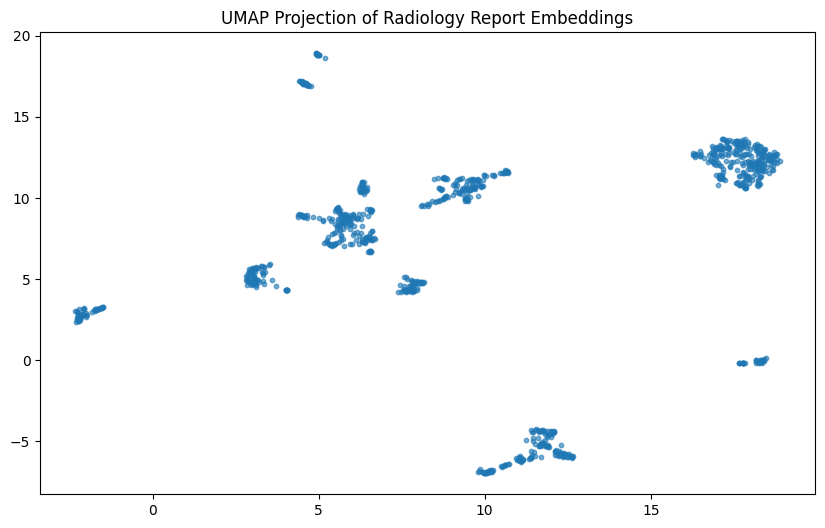

In [ ]:
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=10, alpha=0.6)
plt.title("UMAP Projection of Radiology Report Embeddings")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


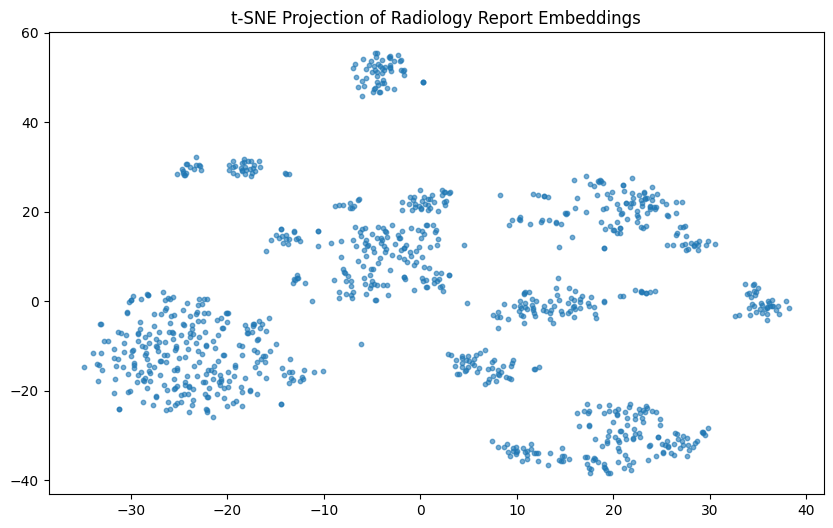

In [ ]:
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42).fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], s=10, alpha=0.6)
plt.title("t-SNE Projection of Radiology Report Embeddings")
plt.show()

In [ ]:
df['umap_x'] = umap_2d[:, 0]
df['umap_y'] = umap_2d[:, 1]
df['tsne_x'] = tsne_2d[:, 0]
df['tsne_y'] = tsne_2d[:, 1]

In [ ]:
umap_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42).fit_transform(embeddings)
df[['umap_x', 'umap_y', 'umap_z']] = umap_3d

# Plot (using Plotly for interactivity)
import plotly.express as px

fig = px.scatter_3d(
    df,
    x='umap_x', y='umap_y', z='umap_z',
    color='field_value',  # Replace with any other column if needed
    title="3D UMAP Projection of Radiology Reports"
)
fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42).fit_transform(embeddings)
df[['tsne_x', 'tsne_y', 'tsne_z']] = tsne_3d

fig = px.scatter_3d(
    df,
    x='tsne_x', y='tsne_y', z='tsne_z',
    color='field_value',
    title="3D t-SNE Projection of Radiology Reports"
)
fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [ ]:
X = np.vstack(df['embedding'].values)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.3, min_samples=5, metric='cosine')
df['dbscan_label'] = dbscan.fit_predict(X)

In [ ]:
from sklearn.cluster import KMeans

k = 10  # or use elbow method to estimate
kmeans = KMeans(n_clusters=k, random_state=42)
df['kmeans_label'] = kmeans.fit_predict(X)

In [ ]:
import plotly.express as px

fig = px.scatter(
    df,
    x='umap_x', y='umap_y',
    color='dbscan_label',  # or 'kmeans_label'
    title="UMAP Projection Colored by DBSCAN Clusters"
)
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter(
    df,
    x='umap_x', y='umap_y',
    color='kmeans_label',
    title="UMAP Projection Colored by DBSCAN Clusters"
)
fig.show()

In [ ]:
import re

def extract_section(text, section_name):
    pattern = rf"{section_name.upper()}:(.*?)(?=\n[A-Z ]+:|\Z)"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(1).strip() if match else None

df['findings'] = df['text'].apply(lambda x: extract_section(x, 'FINDINGS'))
df['impression'] = df['text'].apply(lambda x: extract_section(x, 'IMPRESSION'))


In [ ]:
import pandas as pd
def clean_text(text):
    if pd.isna(text):
        return ""
    return ' '.join(text.strip().split())

df['findings_clean'] = df['findings'].apply(clean_text)
df['impression_clean'] = df['impression'].apply(clean_text)

In [ ]:
df['findings_embedding'] = df['findings_clean'].apply(lambda x: model.encode(x, convert_to_numpy=True))
df['impression_embedding'] = df['impression_clean'].apply(lambda x: model.encode(x, convert_to_numpy=True))

In [ ]:
X_findings = np.vstack(df['findings'].values)
X_impression = np.vstack(df['impression'].values)
